# Task 2 - Natural Language Processing

## Structured Perceptron

### Rubén Barco Terrones - Aleix Casellas Comas - Andreu Masdeu Ninot - Pablo Lázaro Herrasti

##### Imports

In [1]:
#### Basics
import pandas as pd
import numpy as np
%matplotlib inline

import pickle
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

#### skseq Sequences
import scipy
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import skseq
from skseq.sequences import sequence
from skseq.sequences.sequence import Sequence
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.label_dictionary import LabelDictionary

#### Feature mapper
import pprint
from skseq.sequences import extended_feature

#### Structured perceptron
import skseq.readers.pos_corpus
import skseq.sequences.structured_perceptron as spc

#### Functions:

In [72]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# TEST AND PREPROCESSING (NER_DATASET)

In [2]:
# data = pd.read_csv("ner_dataset.csv",encoding="latin1")
# data.head()

### Preparing data

In [3]:
def build_word_to_pos(X):

    word_to_pos = {}
    i = 0
    for s in X:
        for w in s:
            if w not in word_to_pos:
                word_to_pos[w] = i
                i +=1
                
    pos_to_word = {v: k for k, v in word_to_pos.items()}
    return word_to_pos, pos_to_word
            
def build_tag_to_pos(Y):
    tag_to_pos = {}
    i = 0
    for s in Y:
        for t in s:
            if t not in tag_to_pos:
                tag_to_pos[t] = i
                i +=1
    pos_to_tag = {v: k for k, v in tag_to_pos.items()}

    return tag_to_pos, pos_to_tag

### Train

In [4]:
# sentence_formatter = "Sentence: {}"

# last_n_train = 35971
# end_train   = data.index[data["Sentence #"] == sentence_formatter.format(last_n_train)][0]
# train = data[0:end_train]

# n_sentences_train = len(list(set(train["Sentence #"])))
# first_n_train = 1
# last_n_train = last_n_train -1
# print(n_sentences)

In [5]:
# n_sentences_train = len(list(set(train["Sentence #"])))

In [6]:
# %%time 
# sentence_formatter = "Sentence: {}"

# for s_id in  range(first_n_train, last_n_train):
#     print("current {}/{}".format(s_id,last_n_train), end="\r")
#     sentence_id = sentence_formatter.format(s_id)
#     sentence_id_next = sentence_formatter.format(s_id + 1)
#     start = train.index[train["Sentence #"] == sentence_id][0]
#     end   = train.index[train["Sentence #"] == sentence_id_next][0]
#     train["Sentence #"][start:end] = sentence_id
    
# sentence_id = sentence_formatter.format(last_n_train)
# start = train.index[train["Sentence #"] == sentence_id][0]
# end   = train.shape[0]
# train["Sentence #"][start:end] = sentence_id

In [7]:
# train.to_csv('train.csv', sep='\t')

In [8]:
# X_train = []
# Y_train = []

# sentence_formatter = "Sentence: {}"

# for i in range(1,n_sentences_train):
#     s = sentence_formatter.format(i)
#     X_train.append(list(train[train["Sentence #"]==s]["Word"].values))
#     Y_train.append(list(train[train["Sentence #"]==s]["Tag"].values))

In [9]:
# with open("X_train.txt", "wb") as fp:   #Pickling
#     pickle.dump(X_train, fp)
# with open("Y_train.txt", "wb") as fp:   #Pickling
#     pickle.dump(Y_train, fp)

In [10]:
with open("X_train.txt", "rb") as fp:   # Unpickling
    X_train = pickle.load(fp)
with open("Y_train.txt", "rb") as fp:   # Unpickling
    Y_train = pickle.load(fp)

In [11]:
i = 0
xy = ["{}/{}".format(x,y) for x,y in zip(X_train[i],Y_train[i])]
" ".join(xy)

'Thousands/O of/O demonstrators/O have/O marched/O through/O London/B-geo to/O protest/O the/O war/O in/O Iraq/B-geo and/O demand/O the/O withdrawal/O of/O British/B-gpe troops/O from/O that/O country/O ./O'

In [12]:
word_to_pos, pos_to_word = build_word_to_pos(X_train)
tag_to_pos, pos_to_tag  = build_tag_to_pos(Y_train)

len(word_to_pos), len(tag_to_pos)

(30863, 17)

In [13]:
X_ids_train = [[word_to_pos[w] for w in s] for s in X_train]
Y_ids_train = [[tag_to_pos[t] for t in s] for s in Y_train]

In [14]:
# sequence_list = SequenceList(LabelDictionary(word_to_pos), LabelDictionary(tag_to_pos))
# for x,y in zip(X_train,Y_train):
#     sequence_list.add_sequence(x,y, LabelDictionary(word_to_pos), LabelDictionary(tag_to_pos))

In [15]:
# sequence_list[0].to_words(sequence_list=sequence_list)

In [16]:
# with open('sequence_list_train', 'wb') as sqq:
 
#     pickle.dump(sequence_list, sqq)

In [17]:
with open("sequence_list_train", "rb") as fp:   # Unpickling
    sequence_list_train = pickle.load(fp)

In [18]:
sequence_list_train[3]

49/0 50/0 9/0 51/0 1/0 52/0 53/0 54/0 55/0 56/0 57/0 58/0 59/0 60/0 21/0 

### Test

In [19]:
# sentence_formatter = "Sentence: {}"

# test = data[end_train:len(data)]

# n_sentences_test = len(list(set(test["Sentence #"])))
# first_n_test = last_n_train + 1
# last_n_test = 47959
# print(n_sentences_test)

In [20]:
# %%time 
# sentence_formatter = "Sentence: {}"

# for s_id in  range(first_n_test, last_n_test):
#     print("current {}/{}".format(s_id,last_n_test), end="\r")
#     sentence_id = sentence_formatter.format(s_id)
#     sentence_id_next = sentence_formatter.format(s_id + 1)
#     start = data.index[data["Sentence #"] == sentence_id][0]
#     end   = data.index[data["Sentence #"] == sentence_id_next][0]
#     data["Sentence #"][start:end] = sentence_id
    
# sentence_id = sentence_formatter.format(last_n_test)
# start = data.index[data["Sentence #"] == sentence_id][0]
# end   = data.shape[0]
# data["Sentence #"][start:end] = sentence_id

In [21]:
# test.to_csv('test.csv', sep='\t')

In [22]:
# X_test = []
# Y_test = []

# sentence_formatter = "Sentence: {}"

# for i in range(n_sentences_train+1,n_sentences_train+n_sentences_test-1):
#     s = sentence_formatter.format(i)
#     X_test.append(list(data[data["Sentence #"]==s]["Word"].values))
#     Y_test.append(list(data[data["Sentence #"]==s]["Tag"].values))

In [23]:
# with open("X_test.txt", "wb") as fp:   #Pickling
#     pickle.dump(X_test, fp)
# with open("Y_test.txt", "wb") as fp:   #Pickling
#     pickle.dump(Y_test, fp)

In [24]:
with open("X_test.txt", "rb") as fp:   # Unpickling
    X_test = pickle.load(fp)
with open("Y_test.txt", "rb") as fp:   # Unpickling
    Y_test = pickle.load(fp)

In [25]:
i = 0
xy = ["{}/{}".format(x,y) for x,y in zip(X_test[i],Y_test[i])]
" ".join(xy)

'Officials/O said/O Sunday/B-tim Jean/B-per Rene/I-per Anthony/I-per was/O killed/O in/O a/O shootout/O with/O police/O near/O the/O capital/O city/O of/O Port-au-Prince/B-geo ./O'

In [26]:
Y_ids_test = [[tag_to_pos[t] for t in s] for s in Y_test]

# EXPERIMENT 1: Basic features

##### Comments:
Blablablablabla

### Extended features

In [27]:
ex_feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(sequence_list_train) 
ex_feature_mapper.build_features()
pprint.pprint(list(ex_feature_mapper.__dict__.keys()))

['feature_dict',
 'feature_list',
 'add_features',
 'dataset',
 'node_feature_cache',
 'initial_state_feature_cache',
 'final_state_feature_cache',
 'edge_feature_cache']


In [28]:
len(ex_feature_mapper.feature_dict)

38313

In [29]:
ex_feature_mapper.feature_dict

{'init_tag:O': 0,
 'id:Thousands::O': 1,
 'id:of::O': 2,
 'prev_tag:O::O': 3,
 'id:demonstrators::O': 4,
 'id:have::O': 5,
 'id:marched::O': 6,
 'id:through::O': 7,
 'id:London::B-geo': 8,
 'prev_tag:O::B-geo': 9,
 'id:to::O': 10,
 'prev_tag:B-geo::O': 11,
 'id:protest::O': 12,
 'id:the::O': 13,
 'id:war::O': 14,
 'id:in::O': 15,
 'id:Iraq::B-geo': 16,
 'id:and::O': 17,
 'id:demand::O': 18,
 'id:withdrawal::O': 19,
 'id:British::B-gpe': 20,
 'prev_tag:O::B-gpe': 21,
 'id:troops::O': 22,
 'prev_tag:B-gpe::O': 23,
 'id:from::O': 24,
 'id:that::O': 25,
 'id:country::O': 26,
 'id:.::O': 27,
 'final_prev_tag:O': 28,
 'id:Families::O': 29,
 'id:soldiers::O': 30,
 'id:killed::O': 31,
 'id:conflict::O': 32,
 'id:joined::O': 33,
 'id:protesters::O': 34,
 'id:who::O': 35,
 'id:carried::O': 36,
 'id:banners::O': 37,
 'id:with::O': 38,
 'id:such::O': 39,
 'id:slogans::O': 40,
 'id:as::O': 41,
 'id:"::O': 42,
 'id:Bush::B-per': 43,
 'prev_tag:O::B-per': 44,
 'id:Number::O': 45,
 'prev_tag:B-per::O'

#### Training structured perceptron

In [29]:
corpus = skseq.readers.pos_corpus.PostagCorpus()
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, ex_feature_mapper)
sp.num_epochs = 5

In [30]:
sp.get_num_states(), sp.get_num_observations()

(17, 30863)

In [31]:
%%time
num_epochs = 2
sp.fit(ex_feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.893649
Epoch: 1 Accuracy: 0.932477
Wall time: 10min 38s


In [35]:
sp.save_model("perceptron_ex")

In [30]:
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, ex_feature_mapper)
sp.load_model(dir="perceptron_ex")

#### Testing

In [31]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

y_pred_2 = []
y_true = [item for x in Y_ids_test for item in x]
correct_sentences = 0
n_test = len(X_test)

for i in range(n_test):
    y_pred_aux = sp.predict_tags_given_words(X_test[i])
    y_pred_2.append(y_pred_aux)
    if list(y_pred_aux) == Y_ids_test[i]:
        correct_sentences += 1
    
y_pred = [item for x in y_pred_2 for item in x]
F1_score_multi = f1_score(y_true, y_pred, average=None)
Accuracy = accuracy_score(y_true, y_pred)
print('Accuracy for test is: ' + str(Accuracy))
print('F1-Score for test is: ' + str(np.mean(F1_score_multi)))
print('Correct sentences for test is: ' + str(correct_sentences/n_test))

Accuracy for test is: 0.9469140850398756
F1-Score for test is: 0.6071928788965013
Correct sentences for test is: 0.4755588922255589


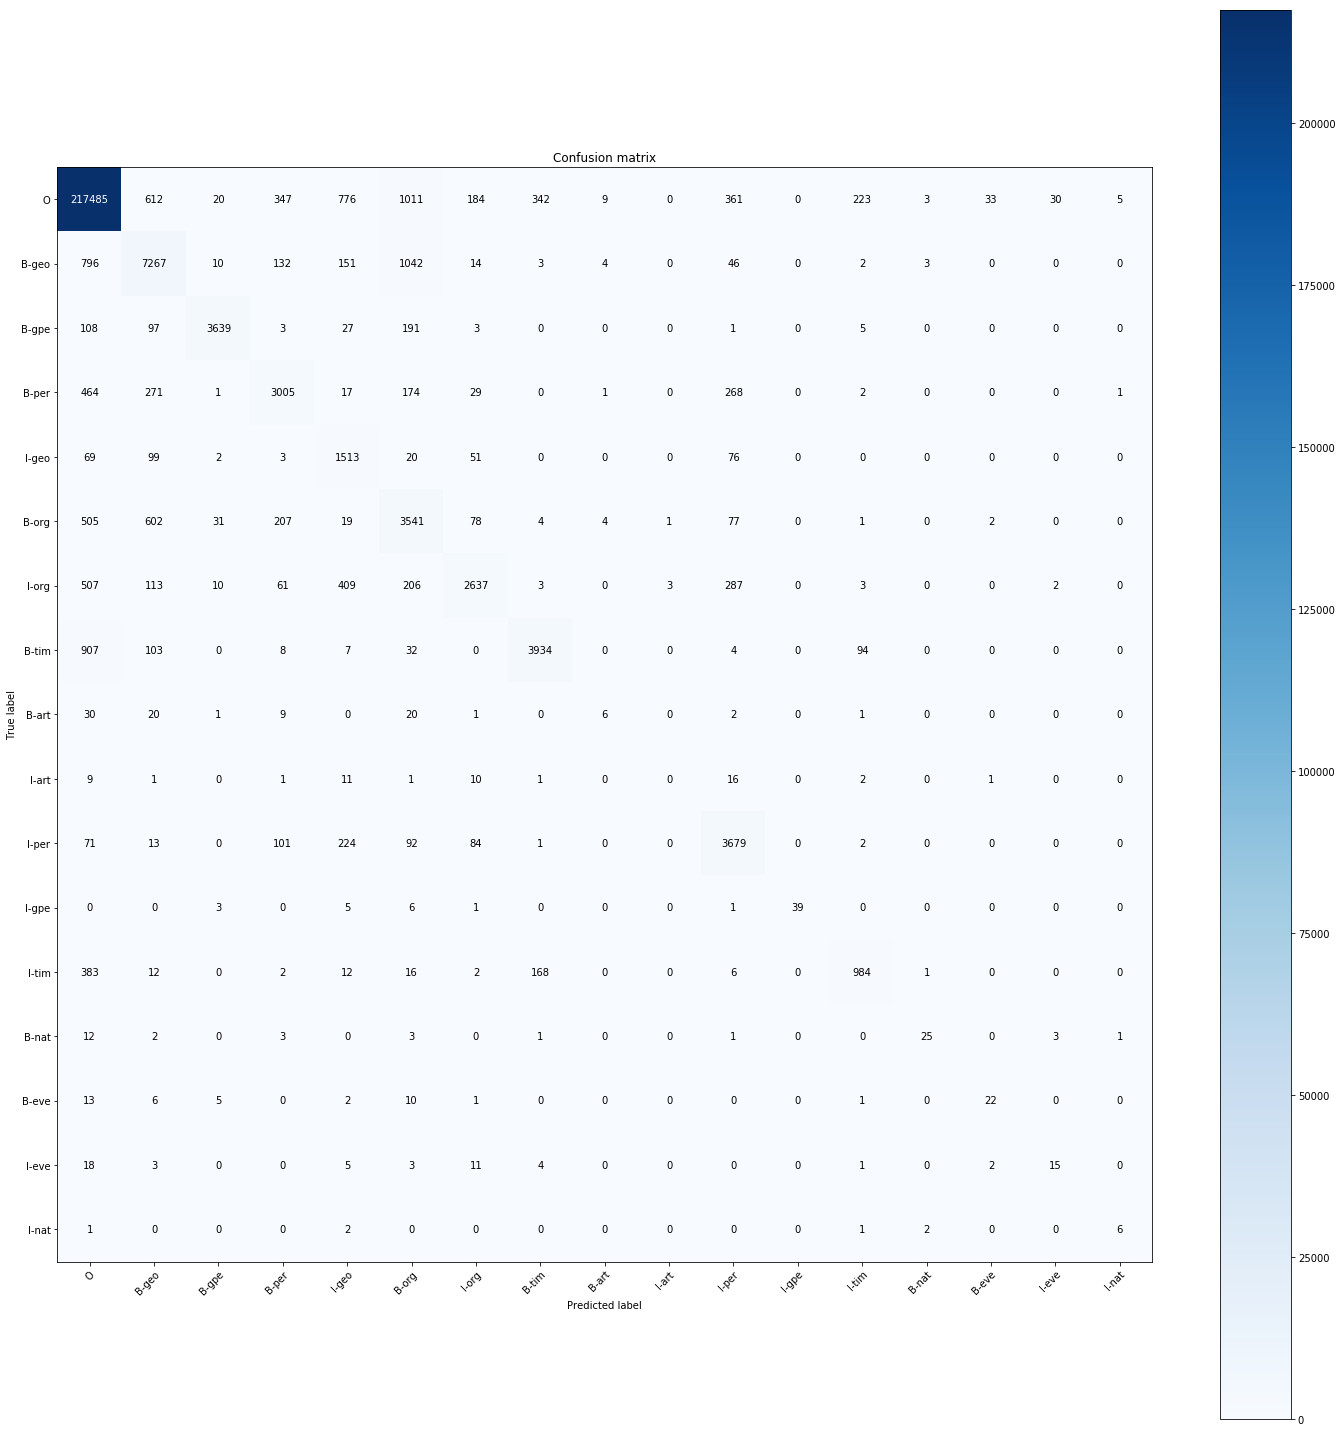

In [71]:
ax = plot_confusion_matrix(y_true, y_pred, classes=list(sp.state_labels),
                      title='Confusion matrix')

# EXPERIMENT 2: 

##### Comments:
